<a href="https://colab.research.google.com/github/so-dipe/working/blob/main/time%20series%20for....ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ok....

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

import libraries

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/so-dipe/working/main/ExportSales.csv')
df.head()

,ID,Date,Category,Invoice Number,Product Code,Customer Code,Destenation,QTY,Total Price
0,2529604,2019-04-28,Category5,267,30011006,612,IRQ,750,3334.8225
1,2529605,2019-04-29,Category5,302,30011006,514,BHR,400,3032.8240
2,2529606,2019-05-13,Category5,507,30011006,513,BHR,100,749.9520
3,2529607,2019-06-01,Category5,795,30011006,5,SYC,100,556.8170
4,2529608,2019-07-03,Category5,1184,30011006,560,AFG,20,39.4460


In [3]:
df.shape

(7811, 9)

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,ID,Date,Category,Invoice Number,Product Code,Customer Code,Destenation,QTY,Total Price
0,2529604,2019-04-28,Category5,267,30011006,612,IRQ,750,3334.8225
1,2529605,2019-04-29,Category5,302,30011006,514,BHR,400,3032.8240
2,2529606,2019-05-13,Category5,507,30011006,513,BHR,100,749.9520
3,2529607,2019-06-01,Category5,795,30011006,5,SYC,100,556.8170
4,2529608,2019-07-03,Category5,1184,30011006,560,AFG,20,39.4460


In [5]:
df.set_index('Date', inplace=True)
df.head()

,ID,Category,Invoice Number,Product Code,Customer Code,Destenation,QTY,Total Price
Date,,,,,,,,
2019-04-28,2529604,Category5,267,30011006,612,IRQ,750,3334.8225
2019-04-29,2529605,Category5,302,30011006,514,BHR,400,3032.8240
2019-05-13,2529606,Category5,507,30011006,513,BHR,100,749.9520
2019-06-01,2529607,Category5,795,30011006,5,SYC,100,556.8170
2019-07-03,2529608,Category5,1184,30011006,560,AFG,20,39.4460


In [6]:
df.drop(columns=['ID', 'Invoice Number', 'Product Code', 'Customer Code', 'Destenation', 'Category'], inplace=True)
df.head()

,QTY,Total Price
Date,,
2019-04-28,750,3334.8225
2019-04-29,400,3032.8240
2019-05-13,100,749.9520
2019-06-01,100,556.8170
2019-07-03,20,39.4460


In [7]:
weekly_df = df.resample('1W').sum().fillna(method='ffill')
weekly_df.head()

,QTY,Total Price
Date,,
2019-04-07,455,11196.14650
2019-04-14,2100,5354.62200
2019-04-21,1700,5554.56300
2019-04-28,7450,33988.10050
2019-05-05,9595,49606.51738


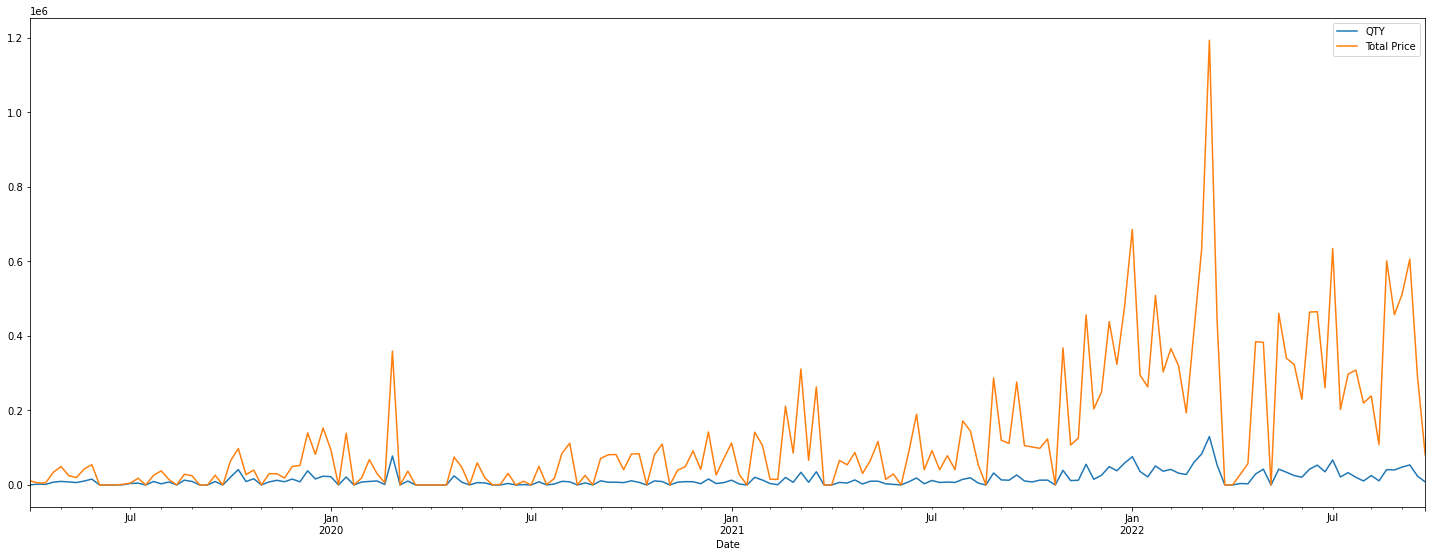

In [8]:
fig, ax = plt.subplots(figsize=(25, 9))
weekly_df.plot(kind='line', ax=ax);

Up to this point, all I have done is clean the data and get it ready for time series analysis. 

I am going to skip much of (2) and (3) because I don't have the time to do high level EDA. I would just be focusing on Autocorrelation and Partial Autocorrelation. You could explore Moving averages and so on. I might also have to do a seasonality and trend decomposition later on.

Its worth noting that I am using the data on an aggregated weekly period and my focus is on Price.

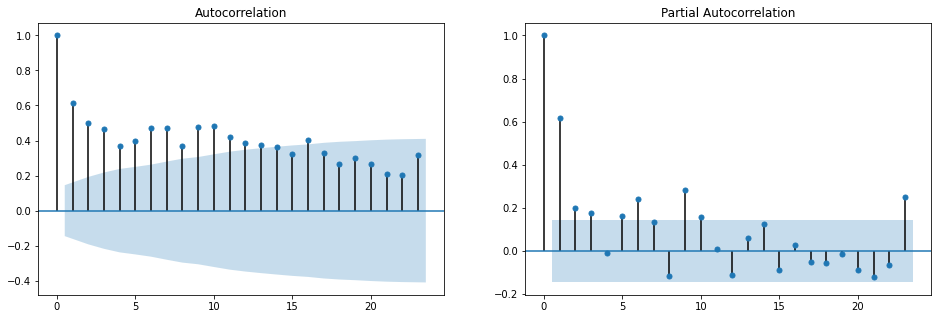

In [9]:
y = weekly_df['Total Price']
fig, ax = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
plot_acf(y, ax[0])
plot_pacf(y, ax=ax[1]);

This plot would give us good values for p and q in the ARMA or ARIMA model.

remember that ARMA stands for Auto Regression Moving Average and ARIMA just has an Integrated. ARMA has two important hyperparamters (p and q), ARIMA includes a third hyperparameter (d). d is determined based on the stationarity of the time series.

In [12]:
#train test split
y_train = y[:160]
y_test = y[160:]

The partial autocorrelation plot shows reasonable values for the hyperparamter (p) while the autocorrelation shows values for (q)

Going back to the autocorrelation and partial autocorrelation plot, values above the shaded portion are statistically significane and might be useful. Values in the shaded region are generally ignored.

The ARIMA model is ARIMA(p, d, q) where p is the hyperparamater that gives the value for the number of coefficients of AR and q gives the number of coefficients (lags) of q. d is used for differencing incase the time series data is not stationary (having constant mean and variance).

In [ ]:
# Building the model
model = ARIMA(y_train, order=(30, 0, 16)).fit()
print(model.summary())

Setting up baselines...

I'm going to use two baselines. 

For the first, I'd assume all the values for the time series as the mean of training set

For the second, I'd use yesterday's value as today's value. (Naive forecast).

In [18]:
y_train_mean = y_train.mean()
y_train_mean_ls = len(y_train) * [y_train_mean]
y_train_base = mean_absolute_error(y_train,  y_train_mean_ls)
print(y_train_base)

101029.38577078676


In [26]:
#shift the values by one day.
# y_train_base['2019-04-07'] = 0
y_train_base = y_train.shift(1).fillna(0)
y_train_base

Date
2019-04-07         0.000000
2019-04-14     11196.146500
2019-04-21      5354.622000
2019-04-28      5554.563000
2019-05-05     33988.100500
                  ...      
2022-03-27    441893.638649
2022-04-03         0.000000
2022-04-10         0.000000
2022-04-17     28159.308800
2022-04-24     57237.148800
Freq: W-SUN, Name: Total Price, Length: 160, dtype: float64

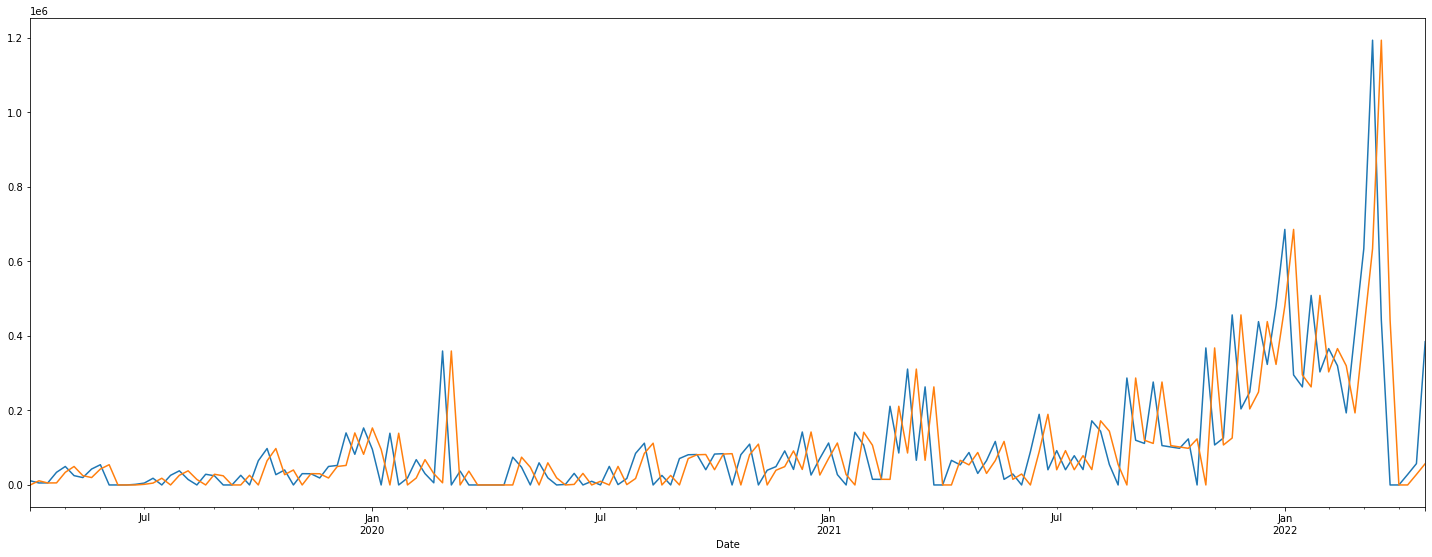

In [27]:
fig, ax = plt.subplots(figsize=(25, 9))
y_train.plot(kind='line', ax=ax);
y_train_base.plot(kind='line', ax=ax);

In [32]:
#get MAE of the naive model.
naive_model_acc = mean_absolute_error(y_train, y_train_base)
naive_model_acc

83291.13583552124

In [33]:
#calculate MAE of ARIMA model
y_train_pred = model.predict()
mean_absolute_error(y_train.values, y_train_pred.values)

64884.27714741377

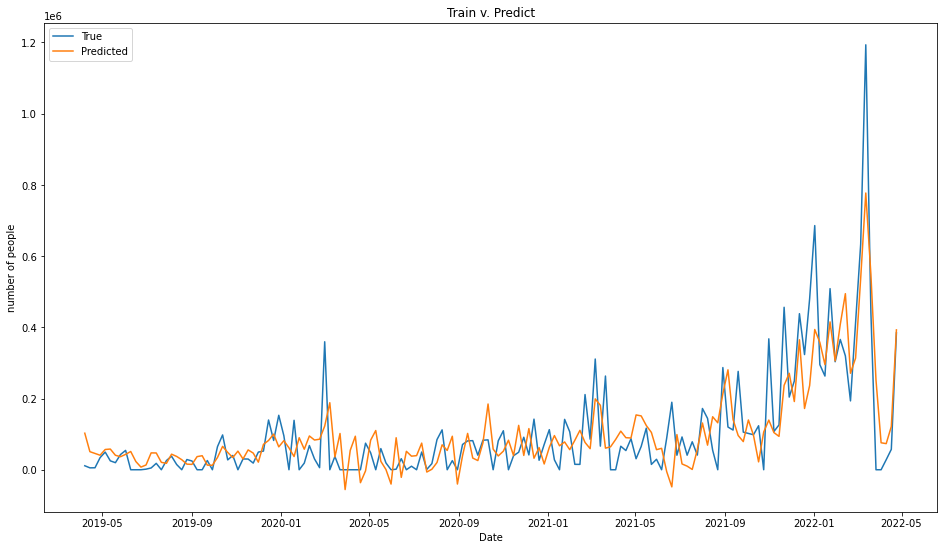

In [34]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(y_train.index, y_train.values, label='True')
plt.plot(y_train.index, y_train_pred.values, label='Predicted')
plt.title('Train v. Predict')
plt.xlabel('Date')
plt.ylabel('number of people')
plt.legend();

In [36]:
#check for stationarity of time series using ADF test.
adf = adfuller(y_train)
print('Test Statistic: ', adf[0])
print('p-value: ', adf[1])
print('Critical Values: ')
for key, value in adf[4].items():
  print('\t%s: %.3f' % (key, value))

Test Statistic:  -0.2258888956281339
p-value:  0.9353645494457652
Critical Values: 
	1%: -3.475
	5%: -2.881
	10%: -2.577


The p-value from adfuller test is greater than 0.05, so the time series is not stationary. I won't talk about the null hypothesis here ....


Next, an ARIMA model with differencing

In [43]:
model = ARIMA(y_train, order=(30, 1, 16)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [44]:
y_train_pred = model.predict()
mean_absolute_error(y_train.values, y_train_pred.values)

63746.63152397401

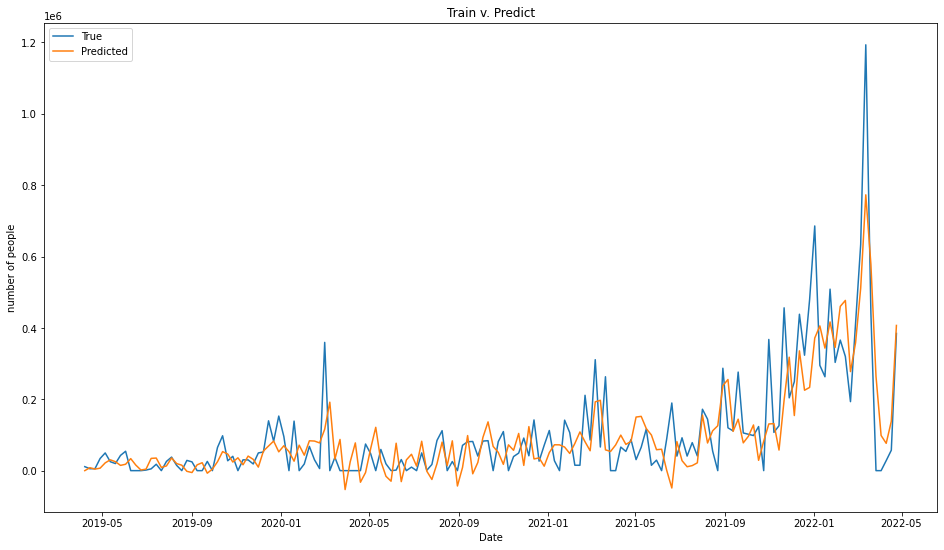

In [45]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(y_train.index, y_train.values, label='True')
plt.plot(y_train.index, y_train_pred.values, label='Predicted')
plt.title('Train v. Predict')
plt.xlabel('Date')
plt.ylabel('number of people')
plt.legend();